# How do transformers find the minimum of a list?


During the Apart interpretability hackathon in November 2022, my group and I focussed on trying to understand how a transformer performs the relatively simple task of finding the minimum of a list of integers. We managed to get pretty far with this, but I wasn't entirely satisfied with our final result, so I decided to do some further exploration and tidying up of our results.

In this notebook I will train a super simple transformer to find the minimum of two numbers. I will use Neel Nanda's Transformer Lens library to do this, as well as for the subsequent mechanistic interpretability of the transformer.

I'll then do the interesting part: **I'll understand in excrutiating detail the algorithm implemented by the transformer!**

# Transformer Lens Setup

Note to reader: feel free to ignore this section. The only important points are: I am using Neel Nanda's excellent Transformer Lens library, and this notebook is designed to be run on colab!

Note to Ole: check what stuff here needs to be kept or discarded! Probably loads of bloat.

This setup is copied from Neel's main demo colab notebook for Transformer Lens, which can be found here: https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/Main_Demo.ipynb#scrollTo=V-IJnEFkEBPa

In [1]:
import google.colab
IN_COLAB = True
print("Running as a Colab notebook")
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
%pip install circuitsvis

# PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
# # Install another version of node that makes PySvelte work way faster
# !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
# %pip install git+https://github.com/neelnanda-io/PySvelte.git

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-q9e78khh
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-q9e78khh
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 006599b30fd6950b3b07c54eabbdaa7c36939595
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 89.1 MB/s eta 0:00

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
%matplotlib inline
import time
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display

In [5]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [6]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
import os
try:
  mkdir(Path('/content/'))
except:
  pass
root = Path('/content/a')
try:
  os.mkdir(root)
except:
  pass
large_root = Path('/content/b')
try:
  os.mkdir(large_root)
except:
  pass

# Wrapper for training a transformer 


Summary: this is a function which trains a transformer model on some algorithmic task. In principle this should be able to be used to train transformers on general algotihmic tasks, for any given set of data, function, and desired configuration for a transformer. In practise, I have only used it for a few simple tasks like this!

This code was adapted from our Hackathon submission, which was in turn adapted from Neel's Grokking paper.

The hyperparameters of the optimizer / the scheduler are hard-coded, and copied from those used by Neel in his grokking paper. I'd be lying if I said I'd tried to properly understand all of them, but I think the most important one is setting weight decay all the way to 1.0 (heavy regularisation gives a big incentive to the network to learn the simplest model it can, which helps prevent overfitting).

Aside: I tried to make this a class, but got very bad memory leaks. It would be nice to modularise this more nicely, but it works for my purposes! I also tried to make it a bit nicer using decorators to wrap the train model function, but this ended up being more hastle than it was worth.

In [9]:

%matplotlib inline
import time
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display


def train_model(data, fn, cfg, device='cuda', split=0.7,seed=42,num_epochs=2000):
  def cross_entropy_high_precision(logits, labels):
      logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
      prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
      loss = -torch.mean(prediction_logprobs)
      return loss

  def full_loss(model, data, labels):
      # Take the final position only
      logits = model(data)[:, -1]
      return cross_entropy_high_precision(logits, labels)

  # Do the initial setup
  # Create HookedTransformer Model
  model = HookedTransformer(cfg).to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.98), weight_decay=1.0)
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
  # Generate train and test split
  random.seed(seed)
  random.shuffle(data)
  div = int(split*len(data))
  train, test = torch.tensor(data[:div]).to(device), torch.tensor(data[div:]).to(device)
  train_labels = torch.tensor([fn(x) for x in train]).to(device)
  test_labels = torch.tensor([fn(x) for x  in test]).to(device)

  #Saving the runs
  run_name = f"grok_{int(time.time())}"
  save_every = 1000
  try:
    os.mkdir(root/run_name)
  except:
    pass

  print("device =", device)

  def cross_entropy_high_precision(logits, labels):
      logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
      prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
      loss = -torch.mean(prediction_logprobs)
      return loss


  def full_loss(model, data, labels):
      # Take the final position only
      logits = model(data)[:, -1]
      return cross_entropy_high_precision(logits, labels)

  train_losses = []
  test_losses = []
  for epoch in tqdm.tqdm(range(num_epochs + 1)):
      train_loss = full_loss(model, train, train_labels)
      test_loss = full_loss(model, test, test_labels)
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

      train_loss.backward()
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
      torch.cuda.empty_cache()
        
      if epoch%save_every == 0:
          save_dict = {
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                  'train_loss': train_loss,
                  'test_loss': test_loss,
                  'epoch': epoch,
          }
          torch.save(save_dict, root/run_name/f"{epoch}.pth")
          print(f"Saved model to {root/run_name/f'{epoch}.pth'}")
      
      if epoch % 100 == 0:
        plt.semilogy(list([l for l in train_losses]), color="blue")
        plt.semilogy(list([l for l in test_losses]), color="red")
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.01)

      if epoch % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {train_loss}")
  
  return model

# Some Interpretability Tools


I didn't really need to make these separately for this notebook, but it should make any similar interpretability stuff I do easier!

The underlying information for our models is made accessible via the [Transformer Lens library](https://github.com/neelnanda-io/TransformerLens). The code for the OV copying score functions also came from Neel's Transformer Lens Demo.

In [10]:
import circuitsvis as cv

def plot_logits(model, input):
  input = torch.tensor(input)
  logits, cache = model.run_with_cache(input, remove_batch_dim = True)
  fig, ax = plt.subplots(figsize=(40,4))
  ax.plot(logits[0][-1].cpu().detach().numpy())
  plt.show()

def generate_attn_pattern(model, input):
  input = torch.tensor(input)
  logits, cache = model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["pattern", 0, "attn"]
  return cv.attention.attention_patterns(tokens = [str(t) for t in list(input.detach().cpu().numpy())], attention = attn_pattern)

def OV_copying_score(model):
  OV_circuit_all_heads = model.OV
  OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 
  OV_copying_score2 = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
  return OV_copying_score2

def OV_full_copying_score(model):
  OV_circuit_all_heads = model.OV
  full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads @ model.unembed.W_U
  full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
  full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
  return full_OV_copying_score

# Seeing what happens if we simply embed and then unembed
def embed_unembed_copying_score(model):
  nothing = FactoredMatrix(model.embed.W_E, model.unembed.W_U)
  nothing_eigenvalues = nothing.eigenvalues
  nothing_score = nothing_eigenvalues.sum(dim=-1).real / nothing_eigenvalues.abs().sum(dim=-1)
  return nothing_score


# Training our Model


Here is the configuration of the transformer we will train to find the minimum of two numbers, which range from 0 - 99.

Here are some important aspects to note about the configuration. I have made the configuration as simple as possible, in order to aid in interpreting it.

1 - The dimension space of the model is actually bigger than the range of numbers that can be input to the transformer. (d_model > d_vocab)

2 - I am using a single attention layer, and a single attention head within this layer. (n_layers and n_heads)

3 - I am not applying Layer normalisation.

4 - I am not using the MLP layer.

Note that by default, some form of positional embedding is occurring.

In [11]:
p = 100
d_vocab = p+1
n_ctx = 2

tiny_cfg2 = HookedTransformerConfig(
    d_model=128,
    d_head=128//1,
    n_heads=1,
    attn_only=True,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Check this seed is actually used somewhere lmao
)


Every pair of numbers from 0-99 is being used for either training or validation. Importantly, there is no cross-over between the training and validation datasets.
(I think that) the entire training set is used in a single epoch of training, and the entire validation set is used each time the model is validated. 

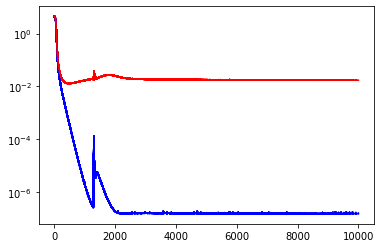

Epoch: 10000. Loss: 1.4813286745722305e-07


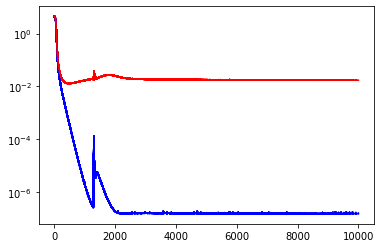

In [12]:
data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=10000)

Let's get the accuracy of the final model:

In [13]:
correct = 0
false = 0
for point in data:
  if int(torch.argmax(small_model(torch.tensor(point))[0][-1])) == min(point):
    correct += 1
  else:
    break
    false += 1

In [14]:
print(correct / (correct + false)) 

1.0


It's pretty good!

# Recap of how GPT-2 style models work


In order to understand the following analysis, I think that it is pretty important to understand how transformers work in general, and I think it is relatively important to understand how GPT-2 style transformers work specifically. I'm not going to go into great detail here, but I will recap some basic points. For a further and more detailed explanation of this, I'd suggest going through Anthropic's "[A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html)", as well as Neel's accompanying walkthrough [video](https://www.youtube.com/watch?v=KV5gbOmHbjU) (I found the latter very useful, to the extent that friends often tease me for bringing it up in conversations).

Attention heads can be broken up into two essentially independent components. The first of these is the QK circuit, which we can think of as governing "which token should the attention head pay attention to". This is then subject to softmax to give us a probability like vector, where each component corresponds to how much the head will pay attention to each token.

The second component of the attention head is the OV circuit. This is what determines the information that should be moved from a token, given that we are paying attention to it.

Generally, a transformer has mutliple sequential attention layers, and each attention layer is formed from multiple attention heads operating in parallel. This makes the transformer able to learn much more complicated behaviour, at the cost of being more difficult to interpret.

However, since our model contains a single attention layer with only one attention head, and as we have no MLP layer or layer norm, if we are able to understand precisely how the QK and OV circuits of our single attention head work, we can describe precisely how our transformer works!

As a small technical note, notice the shape of the output of the model:

In [15]:
input = torch.tensor(np.random.choice(100,2))
small_model.run_with_cache(input)[0].shape

torch.Size([1, 2, 101])

The first index is the batch index (we will just run through one at a time, so this will always be 1 for us). The third index corresponds to the model's predictions: index 0 giving the transformer's probability prediction that the minimum is 0, etc.

The second index corresponds to the output logit at each position. This is essentially an artifact of the architecture of GPT-2 style transformers: in text applications you generally see index 0 being a prediction for the next token after seeing the first token, index 1 being a prediction for the next token after seeing the first two tokens, and so on. We have trained the model only on its predictions after seeing two tokens, so we only care about the -1 element for the second index.

Hopefully, this explains why you may often see me access different aspects of the model by indexing $[0][-1]$ : this is simply how we access the activations of the model that are relevant for how it predicts the minimum.

Ole note: do I need to include this?

#Super Basic Interpretability 

Let's take a look at its attention pattern. This corresponds to the model asking "to which token in the input should the most attention be paid", or more technically the softmax of the output of the QK circuit.

In [16]:
generate_attn_pattern(small_model, torch.tensor([90,25]))

<ipython-input-10-1936fffec4a0>:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [17]:
generate_attn_pattern(small_model, torch.tensor([4,30]))

<ipython-input-10-1936fffec4a0>:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



The bottom row of these plots are what are relevant for us. These show clearly that the QK circuit is successfully paying attention to the smallest number in the pair.

 Let's have a look at its logits, for this random input. As a reminder, logits are the raw output of the transformer, before we apply softmax to the outputs to get a probabilistic looking answer.

<ipython-input-10-1936fffec4a0>:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



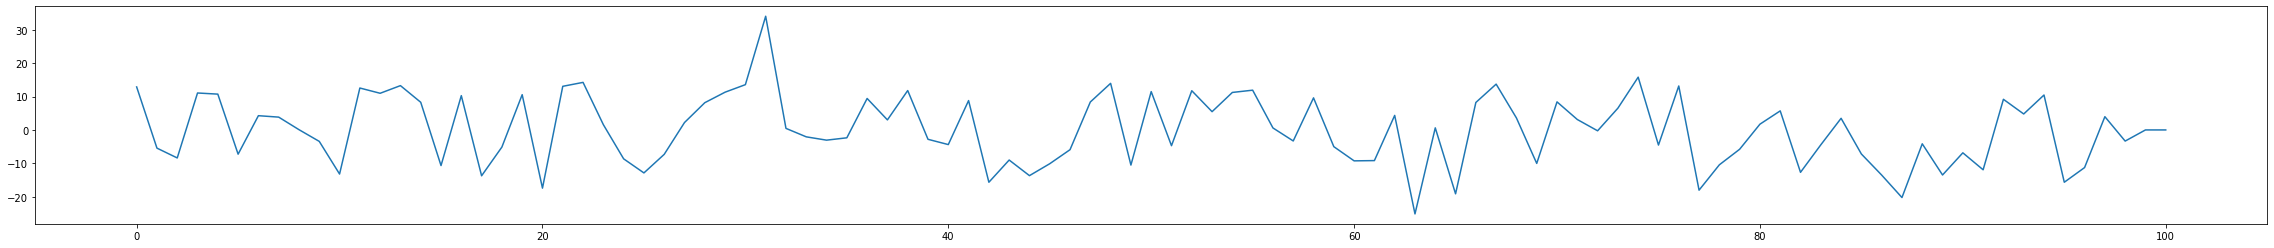

In [18]:
plot_logits(small_model, torch.tensor([31, 44]))

The only distinguishable pattern here is that there is a clear peak at the minimum (31), with what looks essentially like noise for all other values.

This is essentially where we got to at the end of the Hackathon (most of our time was spent trying to train a transformer in the first place!). The story we could convincingly tell at the end of this was "transformers pay the most attention to the token corresponding to the smallest input". 

Although I still agree this is true, I think we can tell a more comprehensive story than this!

# *Interesting part* How I think it is working

Here is how I think the transformer is working. I'll try to highlight my key uncertainties, and why my justification for each claim.

Overall, I think the algorithm being carried out by the transformer is:
1. Pay attention to an input number, corresponding to how small that input is. The smaller the number, the more attention we pay to that input.
2. Then, once we are paying attention to a number, we are going to simply copy over the vector corresponding to that number, and add it to the residual stream. 
3. If the size of the vector we copy over is really big, then it will dwarf the original vector in the residual stream. This essentially means it is just replacing the original vector with the new one!

## Claim 1: attention scores are negatively proportional to the size of the number.

Our first basic look at attention patterns suggested that the model pays most attention to smaller tokens. But we can do a fair bit better than this.

Firstly, let's hold the second token constant at say 50, and vary the first token we give as input.

We then look at the attention that the QK circuit gives to the first token, i.e. that which we vary:

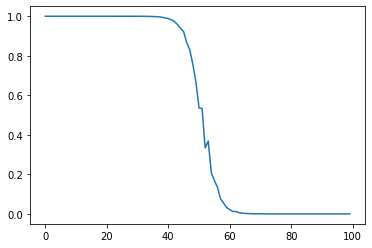

In [19]:
# Hold the second token constant, look at the attention pattern
attn_to_i = []
for i in range(100):
  input = torch.tensor([i, 50])
  logits, cache = small_model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["pattern", 0, "attn"]
  attn_to_i.append(float(attn_pattern[0][-1][0]))

plt.plot(range(100), attn_to_i)


This looks remarkably like a negative sigmoid function! To unpack this a bit further, let's look at the raw attention scores (attention before we apply softmax).

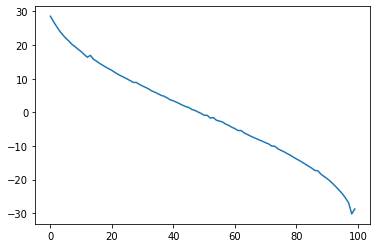

In [20]:
attn_to_i = []
for i in range(100):
  input = torch.tensor([i, 50])
  logits, cache = small_model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["attn_scores", 0, "attn"]
  attn_to_i.append(float(attn_pattern[0][-1][0]))

plt.plot(range(100),attn_to_i)

This looks remarkably smooth! Besides the slight bumps, it has learned a decreasing relationship between attention score and size of the number.

Let's repeat this whilst varying the right hand side instead of the left, and let's change the value from 50 to, say 25

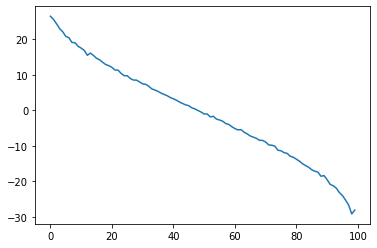

In [21]:
attn_to_i = []
for i in range(100):
  input = torch.tensor([50, i])
  logits, cache = small_model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["attn_scores", 0, "attn"]
  attn_to_i.append(float(attn_pattern[0][-1][1]))

plt.plot(range(100),attn_to_i)

Maybe not exactly the same, but by and large this is equivalent!

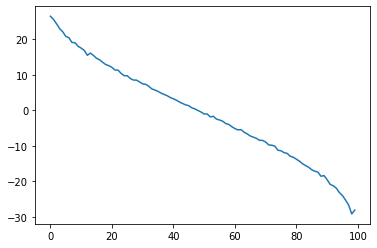

In [22]:
attn_to_i = []
for i in range(100):
  input = torch.tensor([4, i])
  logits, cache = small_model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["attn_scores", 0, "attn"]
  attn_to_i.append(float(attn_pattern[0][-1][1]))

plt.plot(range(100),attn_to_i)

Again, this is incredibly similar! 
From these plots, I feel very confident that it is learning a negative relationship here between size of the number, and attention to give it.

###Sub-Question: What is the relationship exactly?

This section is a bit more speculative than the above. However, there are two aspects I would like to investigate a bit more thoroughly: the independence of the query vector (?), and the precise relationship of each curve.

#### Part 1: Why is the attention score curve independent of the source token?

The reason to believe the first point is true is simply by observing that the different curves for attention score we have plotted above all look essentially the same: it seems to make no difference. At first glance this makes very little sense, because the activation is the inner product between the query vector corresponding to the second input (I think?), and the key vector corresponding to the second input.

It is worth remembering that generally speaking, it doesn't make sense to look at q and k values separately: since they are only ever used as a product, we can get all the information we need out of them by looking at the products of the Q and K matrices, hence the term QK circuit.

However, the invariance of the attention score plots to the source token (corresponding to the Q matrix) suggested that something funny was going on: maybe the hard work is all being done by the K matrix here, and we only care about information from the target token?

To investigate this, I first collected all possible key and query activations (this corresponds to finding the key and query matrices, although I'm not sure what the precise relationship is) 

In [23]:
keys = []
queries = []
for i in range(100):
  logits, cache = small_model.run_with_cache(torch.tensor((i, 90)))
  queries.append(cache["q", 0][0][0])
  keys.append(cache["k", 0][0][0])


##### Query Vectors

As a caveat before I do this analysis: I think doing anaylsis of query and key values in this way is generally a bad idea, especially for tasks which are more difficult than this (i.e. basically everything we actually use transformers for in the real world!). That said, let's look at some random query vectors:

In [43]:
print("First 10 entries of the query vector produced by 25: ", queries[25][0][:10])
print("First 10 entries of the query vector produced by 26: ", queries[26][0][:10])

First 10 entries of the query vector produced by 25:  tensor([ 0.3183, -0.3371,  0.3214,  0.3423, -0.1536,  0.3249,  0.3030,  0.3249,
         0.1756, -0.3324], device='cuda:0')
First 10 entries of the query vector produced by 26:  tensor([ 0.2492, -0.2662,  0.2553,  0.2694, -0.1086,  0.2571,  0.2415,  0.2553,
         0.1370, -0.2612], device='cuda:0')


In [44]:
print("First 10 entries of the query vector produced by 50: ", queries[50][0][:10])
print("First 10 entries of the query vector produced by 90: ", queries[90][0][:10])

First 10 entries of the query vector produced by 50:  tensor([ 0.3160, -0.3375,  0.3217,  0.3418, -0.1440,  0.3247,  0.3038,  0.3237,
         0.1687, -0.3319], device='cuda:0')
First 10 entries of the query vector produced by 90:  tensor([ 0.2809, -0.2975,  0.2825,  0.3016, -0.1411,  0.2860,  0.2669,  0.2867,
         0.1531, -0.2937], device='cuda:0')


These all look suspiciously similar!! Looking at the norms of the query vectors:

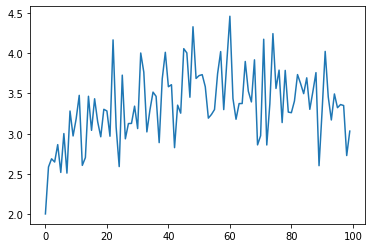

In [32]:
plt.plot(range(100), [torch.norm(queries[i]).cpu() for i in range(100)])

I think that the norms look relatively randomly distributed. There might be some trend (maybe it trends down at the start?), but I'm somewhat confident in the claim that the meaningful information regarding the attention scores is not to be found here: to the queries we go!

##### Key Vectors

Now, if the information about the size of a number isn't being encoded in the query matrix, it must be in the key matrix! Let's have a look at some of these to work out if this is true

In [46]:
print("First 10 entries of the key vector produced by 25: ", keys[25][0][:10])
print("First 10 entries of the key vector produced by 26: ", keys[26][0][:10])


First 10 entries of the key vector produced by 25:  tensor([ 0.3713, -0.3970,  0.3775,  0.4018, -0.1722,  0.3813,  0.3563,  0.3803,
         0.1977, -0.3900], device='cuda:0')
First 10 entries of the key vector produced by 26:  tensor([ 0.3518, -0.3777,  0.3593,  0.3816, -0.1590,  0.3627,  0.3399,  0.3609,
         0.1850, -0.3705], device='cuda:0')


In [45]:
print("First 10 entries of the key vector produced by 74: ", keys[74][0][:10])
print("First 10 entries of the key vector produced by 75: ", keys[75][0][:10])

First 10 entries of the key vector produced by 74:  tensor([-0.4080,  0.4357, -0.4133, -0.4403,  0.1991, -0.4179, -0.3910, -0.4176,
        -0.2169,  0.4285], device='cuda:0')
First 10 entries of the key vector produced by 75:  tensor([-0.4260,  0.4539, -0.4303, -0.4594,  0.2103, -0.4355, -0.4062, -0.4357,
        -0.2272,  0.4468], device='cuda:0')


Given the earlier caveat of looking at key and query vectors directly, there definitely looks like a pattern here: the components all look relatively uniform, either increasing or decreasing towards 0, and then either decreasing or increasing afterwards.

This seems to suggest that magic formula being used by the key vectors to capture how big different numbers are is: just encode it in the magnitude of the key vector!

Let's first look at the norm for key vectors across all possible inputs:

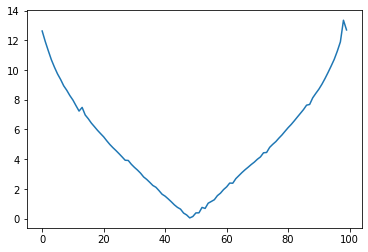

In [29]:
plt.plot(range(100), [torch.norm(keys[i]).cpu() for i in range(100)])

This is certainly capturing some relationship, but not necessarily the relationship, but it isn't the whole story. 

To help see why, notice that the sign of the components of the vectors either matches with the query vectors for every component, or it is the opposite for every component. This makes sense: if you're trying to make a big inner product, you want each term in the inner product to be positive; if you're trying to make a large negative inner product, you want each term in the inner product to be negative.

So what's going on with the above plot is that is capturing the size of the eventual inner product (the attention score), but not the sign. If we take into account where the sign flips:

In [30]:
import math

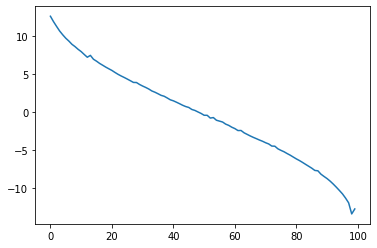

In [31]:
plt.plot(range(100), [math.copysign(1, keys[i][0][0].cpu()) * torch.norm(keys[i]).cpu() for i in range(100)])

This looks exactly like the graph for attention scores we found before!! Hence, we really can say that the attention score is explained solely by the key matrix, and that the attention scores are essentially independent of the query matrices.

So, why do I think that Q and K are meaningfully separate for this example? Again, my guess would be the presence of weight decay: having the size of the query vectors also vary in proportion to the size of the original token would probably be useful if the training process was optimising for was loss, but it might mean we have to have larger weights overall than just keeping the Q vectors roughly constant and letting K vary. I have not tested this explanation much / at all.

##### Tangent: Why not also just look at OV circuits and embeddings directly?

This isn't super relevant to the investigation into this transformer, but I have some guesses as to why QK circuits might be more easily interpretable in general than OV circuits.

I think the main reason is that when the transformer produces its outputs, it actually needs to tell the difference between values that are close together, say 20 and 21. It produces logits by simply applying a linear map to the residual stream. Hence, if we want to produce a large logit corresponding to 20, but not corresponding to 21 or 19, we need the corresponding vectors in the residual stream to be "different" besides just having larger components.

As a tiny bit of evidence for this claim, let's look at the first ten components of the embeddings of 20 and 21. Some of the different components here have different signs, which was not the case when we compared their key or query vectors.

In [68]:
logits, cache = small_model.run_with_cache(torch.tensor((20, 90)))
cache["resid_pre", 0][0][0][:10] # embedding of 20

tensor([ 0.2088, -0.2706, -0.0563,  0.0379,  0.1755, -0.2340,  0.1558,  0.2058,
         0.0841, -0.0773], device='cuda:0')

In [69]:
logits, cache = small_model.run_with_cache(torch.tensor((21, 90)))
cache["resid_pre", 0][0][0][:10] # Embedding of 21

tensor([ 0.1545, -0.2708,  0.0648, -0.0440,  0.1708, -0.2914,  0.2218,  0.0018,
         0.0516, -0.0383], device='cuda:0')

That being said, I plotted the norms of vectors in the residual stream for all different possible inputs in the first position, and the second. There again seems to be a relationship here!!

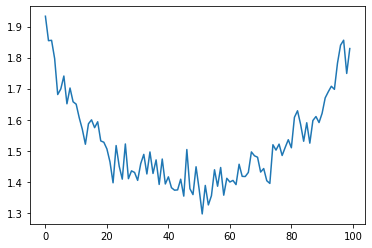

In [64]:
first_embeddings = []
for i in range(100):
  logits, cache = small_model.run_with_cache(torch.tensor((i, 90)))
  first_embeddings.append(cache["resid_pre", 0][0][0])
  
plt.plot(range(100), [torch.norm(embedding).cpu() for embedding in first_embeddings])

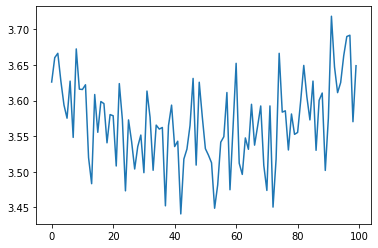

In [67]:
second_embeddings = []
for i in range(100):
  logits, cache = small_model.run_with_cache(torch.tensor((90, i)))
  second_embeddings.append(cache["resid_pre", 0][0][-1])

plt.plot(range(100), [torch.norm(embedding).cpu() for embedding in second_embeddings])


#### Part 2: Why does the attention curve look like that?
Regarding the precise nature of the above curves, my first guess is that they would be linear, and this seems approximately correct. Transformers are able to learn linear relationships well, so it makes sense that this would also learn a linear relationship to distinguish between numbers.

However, the curves above arguably bear more of a resemblence to arctan: they seems to be roughly linear in the middle, before tailing up / down slightly at each end.

I think that this actually makes more sense as a strategy than a simple linear relationship. For example, if you see 0, you know that is the minimum number in the list (because our range is 0-99), and you should therefore pay as much attention to 0 as possible. This means that, ideally, you would pay an infinite amount of attention to it.

Likewise, if you see 99, you know it's definitely the other number, and thus you should pay as little attention to it as possible. The QK circuit is only able to curve the tail so much at each end (due to weight decay limiting how "extreme" the behaviour can be for any given point), but in hindsight I maybe shouldn't have been so surprised to see it learn a relationship with these kinks at either end.

## Claim 2: the attention head is just copying tokens it pays attention to.

I'm basically deferring to the summary statistics developed in the "A Mathematical Framework for Transformers" paper from Anthropic to measure copying. You can see further discussion of them [here](https://transformer-circuits.pub/2021/framework/index.html).

Here are the copying scores both for only the OV circuit, and for the OV circuit with both the embed and unembed layers taken into account.

In [70]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))

tensor([[0.9826]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.9988]], device='cuda:0', grad_fn=<DivBackward0>)


Given that these are good summary statistics, I'm pretty confident that the attention head is just copying here.

## Claim 3: The attention layer is "overpowering" the residual stream.

A further hypothesis I have about this transformer, is that these networks are not simply copying, but are copying an enlarged version of the token. It makes sense to do this because the output of the OV circuit is being added to the residual stream which contains the embedding of the second token. To minimise the extent to which the embedding of the second token influences the output logits, it seems like a useful strategy to copy over a vector which is as large as possible!

Now, if we were using some form of normalisation such as layer norm, this "overpowering" would not be possible, since it would limit the size of the vector we add back to the residual stream. However, this model doesn't use Layer Norm!
(I think this is how layer norm works)

To try to test this, I'm going to go for the simplest measurement I can think of: just compare the l2 norm of the residual stream before we go through the attention layer, with the l2 norm of the activation of the attention layer (which will be added back to the residual stream).

In [71]:
logits, cache = small_model.run_with_cache(torch.tensor([50, 20]), remove_batch_dim=True)

In [72]:
torch.norm(cache["resid_pre", 0][-1])

tensor(3.5786, device='cuda:0')

In [73]:
torch.norm(cache["attn_out", 0][-1])

tensor(24.6327, device='cuda:0')

In [74]:
torch.norm(cache["resid_post", 0][-1])

tensor(26.0758, device='cuda:0')

Here is a little sanity check to ensure that we are actually comparing the correct activations!

In [75]:
cache["resid_pre", 0][-1] + cache["attn_out", 0][-1] == cache["resid_post", 0][-1]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True], device='cuda:0')

Now, I'll calculate the average ratio of the output of the attention layer divided by the residual stream before the attention layer, across 100 random inputs.

In [77]:
resid_pre = []
attn_out = []
for i in range(100):
  input = torch.tensor(np.random.choice(100,2))
  logits, cache = small_model.run_with_cache(input, remove_batch_dim=True)
  resid_pre.append(torch.norm(cache["resid_pre", 0][-1]))
  attn_out.append(torch.norm(cache["attn_out", 0][-1]))

ratios = [post / pre for (post, pre) in zip(attn_out, resid_pre)]
sum(ratios)/len(ratios)

tensor(7.2214, device='cuda:0')

The output of the attention layer is on average 7x greater than the output of residual stream! Despite the crudeness of this statistic, it feels like relevant information nonetheless. 

My guess as to why the output of the attention layer isn't even bigger than this is because of the regularisation applied during training. This also makes the above results more significant: the model is having to pay a high penalty to have the high weights necessary to produce large activations in the output, so the fact it is doing so anyway suggests the size of the activations serves an important purpose.

Why isn't the model removing the residual stream, and replacing it entirely with the output of the attention layer? (Expand) 1-layer transformers cannot do this! (Think about if this is true for transformers with more layers, MLP, etc.)


In fact, I suspect that this might be generalisable to other transformers where a single attention layer is essentially able to compute the correct answer: a strategy of "shout so loud the opinions of others cannot be heard" might well be the learned behaviour here! :)) (expand on this in the takeaways section)

# Takeaways

1 - I was surprised at how easily interpretable the algorithm carried out by the transformer was! I think the main reasons for simplicity were the super simple nature of the task, and the simplicity of the model (alongside the big pressure towards simplicity thanks to the regularisation). However, it has made me update towards thinking that the algorithms implemented by simple transformers are more interpretable in general, even if the training curve isn't displaying "grokking" as clear as in Neel's modular addition example.

2 - I think some of the specific techniques here (like the deep dive into the attention score) probably won't generalise very well to other algorithmic tasks, but I think maybe some aspects like an attention head overpowering the residual stream might.

3 - Generally, using the Transformer Lens library was pretty straightforward, and made this work much easier than it would have been otherwise!

# Further Research

1 - For this task specifically, which aspects of the explanations generalise to different model architectures? What about to finding the minimum of a larger list (I'd guess it does)? What if we reduce the extent we regularise the model during training?

2 - Can we incorporate an analysis of positional embedding for this task?

3 - How do transformers embed numbers internally? Especially for smaller values of d_model compared to the number of distinct values it has to learn.

4 - Are OV copying scores actually a good measure of whether a transformer is copying? Are there other simple OV behaviours we might look to characterise and measure (such as subtraction)?

5 - I think having some interpretability tools on top of Transformer Lens could be useful, although this depends on how difficult they are to implement / how useful a single function is to investigate a range of different tasks / transformers.